In [1]:
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams['image.cmap'] = 'gray'


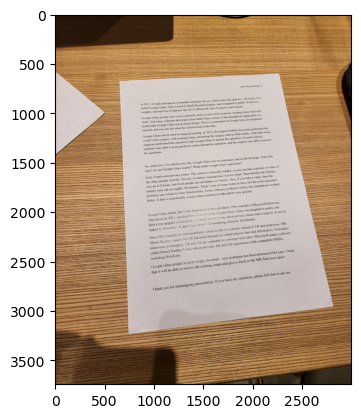

In [2]:
img = cv2.imread("test/photo1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [3]:
def get_white_area(img: cv2.Mat) -> cv2.Mat:
    """R, G, B 값이 특정 threshold 이상인 픽셀을 1로 mask한다. Threshold method는 Otsu이다.

    Args:
        img (cv2.Mat): RGB image.

    Returns:
        cv2.Mat: 0 또는 255 값을 갖는 bitmask.
    """
    # img는 RGB 순서로 가정. 사실 BGR이어도 큰 문제는 없다.
    _, r_thres = cv2.threshold(img[..., 0], -1, maxval=255, type=cv2.THRESH_OTSU)
    _, g_thres = cv2.threshold(img[..., 1], -1, maxval=255, type=cv2.THRESH_OTSU)
    _, b_thres = cv2.threshold(img[..., 2], -1, maxval=255, type=cv2.THRESH_OTSU)
    return r_thres & g_thres & b_thres


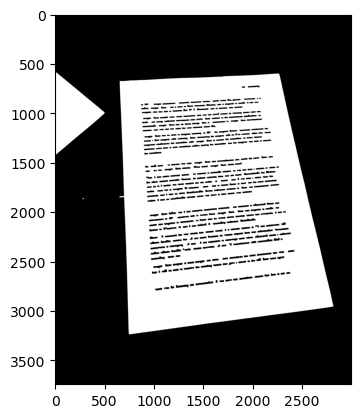

In [4]:
# R, G, B 값이 모두 특정 역치 이상인 점들만 흰색으로 표시한다.
img_thres = get_white_area(img)

# 잔noise들을 없애기 위해 open 및 close를 해 준다.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
cv2.morphologyEx(img_thres, cv2.MORPH_OPEN, kernel, img_thres)
cv2.morphologyEx(img_thres, cv2.MORPH_CLOSE, kernel, img_thres)

plt.imshow(img_thres)


[[[2262  604]]

 [[ 654  678]]

 [[ 746 3240]]

 [[2811 2958]]]


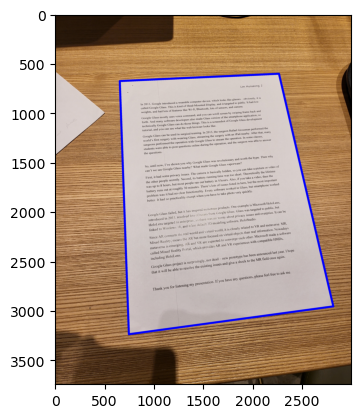

In [5]:
# 얻은 테두리를 표시한다.
h, w, *_ = img.shape
# area_thres = 100000
area_thres = h * w // 4

img2 = img.copy()
contours, _ = cv2.findContours(img_thres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > area_thres:
        approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, closed=True), closed=True)
        if len(approx) == 4:
            cv2.drawContours(img2, [approx], 0, (0, 0, 255), 20)
            break
plt.imshow(img2)
print(approx)

In [6]:
def sort_order(points: cv2.Mat) -> cv2.Mat:
    """좌상, 우상, 우하, 좌하 순서로 재정렬한다."""
    points = points[:, 0, :].astype(np.float32)
    med = np.median(points, axis=0)
    reordered = np.zeros_like(points, dtype=np.float32)
    for point in points:
        if (point[0] < med[0]) and (point[1] < med[0]):  # Top Left
            reordered[0, :] = point[:]
        if (point[0] >= med[0]) and (point[1] < med[0]):  # Top Right
            reordered[1, :] = point[:]
        if (point[0] >= med[0]) and (point[1] >= med[0]):  # Bottom Right
            reordered[2, :] = point[:]
        if (point[0] < med[0]) and (point[1] >= med[0]):  # Bottom Left
            reordered[3, :] = point[:]
    return reordered


[[ 654.  678.]
 [2262.  604.]
 [2811. 2958.]
 [ 746. 3240.]]


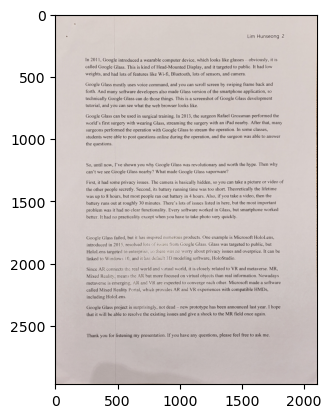

In [7]:
# 일단 A4용지로 제한
width = 210 * 10
height = 297 * 10
src_points = sort_order(approx)
print(src_points)
dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

H = cv2.getPerspectiveTransform(src_points, dst_points)
a4 = cv2.warpPerspective(img, H, (width, height))
plt.imshow(a4)


In [8]:
# GaussianBlur 기반 unsharp filter를 쓰는 경우

# a4_y = cv2.cvtColor(a4, cv2.COLOR_BGR2YCrCb)[..., 0]
# a4_blur = cv2.GaussianBlur(a4_y, (0, 0), 2)

# a4_sharp = cv2.addWeighted(a4_y, 2, a4_blur, -1, 0)
# plt.imshow(a4_sharp)

# cv2.imwrite("a4_sharp.png", a4_sharp)


True

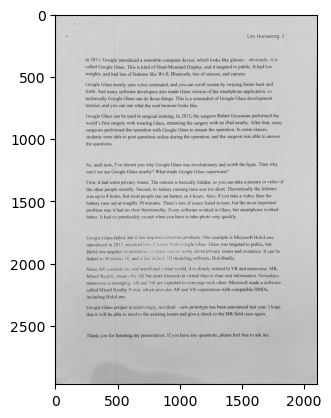

In [9]:
# medianBlur 기반 unsharp filter를 쓰는 경우

a4_y = cv2.cvtColor(a4, cv2.COLOR_BGR2YCrCb)[..., 0]
a4_blur = cv2.medianBlur(a4_y, 3)

a4_sharp = cv2.addWeighted(a4_y, 2, a4_blur, -1, 0)
plt.imshow(a4_sharp)

cv2.imwrite("a4_med_sharp.png", a4_sharp)
